<a href="https://colab.research.google.com/github/Abdulkadir-karatas/FireDetection/blob/master/Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import layers, optimizers, models, preprocessing, losses, callbacks
import os
import random
from PIL import Image
import tensorflow as tf
import keras

In [ ]:
#veri seti

!wget "https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/fire.zip"

!unzip -qo fire.zip

!rm fire.zip

--2025-04-27 14:27:51--  https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/fire.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.156.79, 52.219.158.107, 3.5.212.118, ...
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.156.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102552780 (98M) [application/zip]
Saving to: ‘fire.zip.1’

fire.zip.1          100%[===================>]  97.80M  11.7MB/s    in 21s     

2025-04-27 14:28:13 (4.59 MB/s) - ‘fire.zip.1’ saved [102552780/102552780]



In [ ]:
# dataseti yükleme

path = 'fire/'
input_shape = (256, 256, 3)    # resimlerin varsayılan defoult boyutları

batch = 64

# eğitim ve test verisetleri
print("Train dataset")
train_ds = preprocessing.image_dataset_from_directory(path+'Train', batch_size=batch, label_mode='binary')

print("Test dataset")
test_ds = preprocessing.image_dataset_from_directory(path+'Test', batch_size=batch, label_mode='binary')

print("Validation dataset")
val_ds = preprocessing.image_dataset_from_directory(path+'Vali', batch_size=batch, label_mode='binary')

Train dataset
Found 6003 files belonging to 2 classes.
Test dataset
Found 2000 files belonging to 2 classes.
Validation dataset
Found 2000 files belonging to 2 classes.


In [ ]:
# toplam kullanılan veri setlerini çıktı olarak verme işlemi

for t in ['Train', 'Test', 'Vali']:
    print('\n', t.upper())
    for x in os.listdir(path + t):
        print(x, ' - ', len(os.listdir(path + t + '/' + x)))


 TRAIN
Fire  -  3003
Non-Fire  -  3000

 TEST
Fire  -  1000
Non-Fire  -  1000

 VALI
Fire  -  1000
Non-Fire  -  1000


In [ ]:
# verisetlerini sınıflandırma işlemi (ateş var-yok)

class_names = train_ds.class_names

print("Train class names: ", train_ds.class_names)
print("Test class names: ", test_ds.class_names)
print("Validation class names: ", val_ds.class_names)

Train class names:  ['Fire', 'Non-Fire']
Test class names:  ['Fire', 'Non-Fire']
Validation class names:  ['Fire', 'Non-Fire']


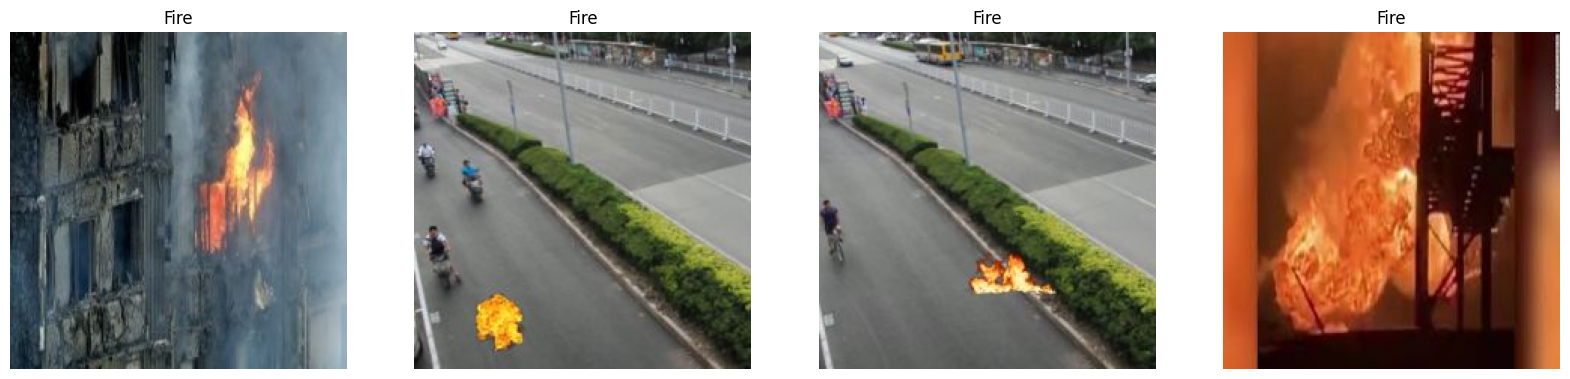

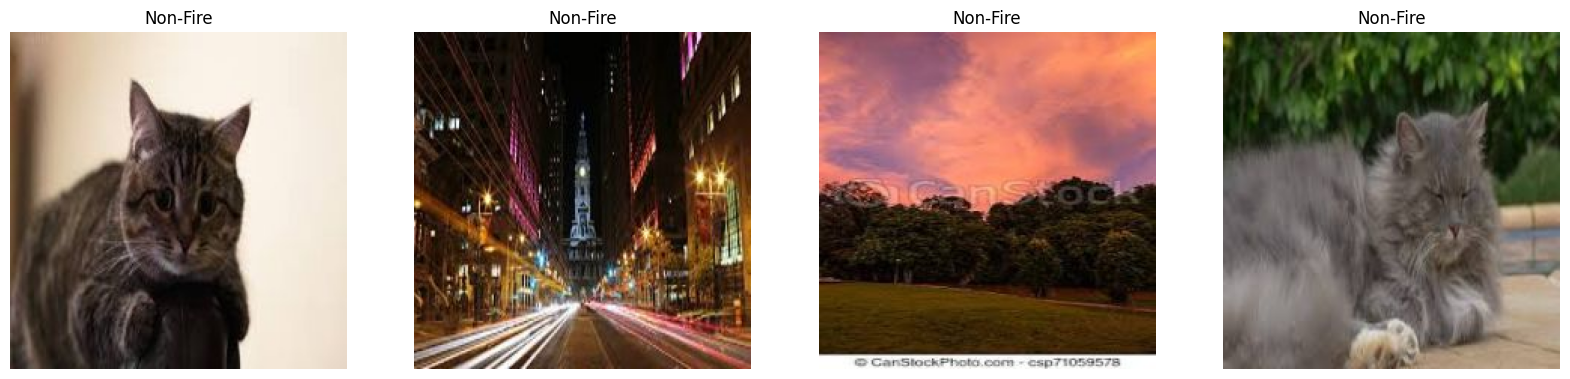

In [ ]:
num_samples = 4    # Her sınıfta kuıllanılacak örnek sayısı
# Belirlenen sınıflardaki görselleri görselleştirme işlemi ve örnek çoğullama işlemi sonucu çıktılar
for x in class_names:
    plt.figure(figsize=(20, 20))

    filenames = os.listdir(path + 'Train/' + x)

    for i in range(num_samples):
        ax = plt.subplot(1, num_samples, i + 1)
        img = Image.open(path +'Train/' + x + '/' + filenames[i])
        plt.imshow(img)
        plt.title(x)
        plt.axis("off")

In [ ]:
# Yakınsama ihtimalini arttırmak için normalizasyon işlemi uygulaması (resimlerdeki pixel değerlerinin)

# veri setlerine ayrı ayrı noralizasyon uygulama
normalization_layer = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
#  Keras kütüphanesi kullanılarak bir transfer öğrenme modeli oluşturma işlemi
base_model = keras.applications.InceptionV3(weights='imagenet', input_shape=input_shape, include_top=False) # InceptionV3 Modelini Yükleme ve InceptionV3 modelini ImageNet ağırlıkları ile yükleme işlemi
base_model.trainable = False # Modeli Sabitleme işlemi

inputs = tf.keras.Input(shape=input_shape)

x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1, activation = 'sigmoid')(x)    # yeni katmanlar ekleme işlemi

model = keras.Model(inputs, outputs) # Modelin Tanımlanması işlemi

cb = [callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)] # Erken Durdurma işlemi
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 6, 6, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,804,833 (83.18 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 21,802,784 (83.17 MB)